# Abstract

*A problem well stated is a problem half-solved.*

*This is your space to describe your intentions for the project, before writing a single line of code. What are you studying? What are you hoping to build? If you can't explain that clearly before you start digging into the data, you're going to have a hard time planning where to go with this.*

# Obtain the Data

*Describe your data sources here and explain why they are relevant to the problem you are trying to solve.*

*Your code should download the data and save it in data/raw. If you've got the data from an offline source, describe where it came from and what the files look like. Don't do anything to the raw data files just yet; that comes in the next step.*

*After completing this step, be sure to edit `references/data_dictionary` to include descriptions of where you obtained your data and what information it contains.*

In [3]:
## %%writefile ../src/data/make_dataset.py

# Imports
from bs4 import BeautifulSoup
import requests
import json


# Parameters
drizly_drinks_path = '../data/raw/drizly_drinks.pickle'

def get_soup(url):
    """
    Given url, return soup. Return None if host unresponsive
    """
    soup = None
    r = requests.get(url, timeout=5)
    if r.ok:
        soup = BeautifulSoup(r.content, 'html.parser')
    return soup


def get_ingredients(soup):
    """
    """
    d = soup.find_all('div', attrs={'data-integration-name':'react-component'})
    info = json.loads(d[1].get('data-payload'))
    productIds = info['props']['productIDs']

    base = 'https://drizly.com/async_catalog_fetch?category_overrides'
    ids = '&product_ids[]='.join(map(str, productIds))
    req = f'{base}&product_ids[]={ids}&product_overrides'
    r = requests.get(req)
    if not r.ok:
        return {}
    products = r.json()
    
    ingr_path = '../data/raw/ingredients.pickle'
    if file_exists(ingr_path):
        ingredients = load_from(ingr_path)
    else:
        ingredients = {}
    drink_ingrs = {}
        
    for p in products['catalogItems']:
        name = p['name']
        attrs = {
            'description': p['description'],
            'url': f"https://drizly.com/{p['click_url']}", 
            'categories': p['category_names']}
        ingredients.setdefault(name, {})
        ingredients[name].update(attrs)
        drink_ingrs[name] = attrs
    save_to(ingredients, ingr_path)
    return drink_ingrs


def get_cocktail_data():
    """
    """
    drink_list = load_from(drizly_drinks_path)
    num_drinks = len(drink_list)
    failures = 0
    for drink, stats in drink_list.items():
        num_drinks -= 1
        f = ['description', 'recipeIngredient', 'name', 'recipeInstructions']
        if len(set(f) & set(stats.keys())) == len(f):
            continue
        try:
            soup = get_soup(stats['url'])
        except:
            failures += 1
            continue

        # Get fields
        data = json.loads(soup.find('script', type='application/ld+json').text)
        stats.update({key: data[key] for key in f})

        def scrape_text(field, tag, tag_class):
            tags = soup.findAll(tag, attrs={'class': tag_class})
            cleaned = lambda t: t.text.replace('\n', '').replace('\xa0', ' ').strip()
            text = [cleaned(t) for t in tags]
            stats.update({field: text})
            return
        
        items = [
            ('tags', 'li', 'Recipe__tag'),
            ('stats', 'li', 'stat'),
            ('tools', 'li', 'Tools__tool')
        ]
        
        # Get items
        for item in items:
            scrape_text(*item)
            
        # Get ingredient data
        drink_ingrs = get_ingredients(soup)
        stats.update({k: v for k, v in drink_ingrs.items()})
        
        print(f'Drinks remaining: {num_drinks}. Got a {drink}.', 
              '\r', end='')
        save_to(drink_list, drizly_drinks_path)
    return drink_list


def get_drink_list(verbose=False):
    """
    """
    url = "https://drizly.com/recipes#all-recipes"
    soup = get_soup(url)
    link_class = "recipe-link"
    data = soup.findAll('li',attrs={'class': link_class})
    drink_list = {}
    for li in data:
        l = li.find('a')
        if l:
            name = l.text.replace('\n', '').replace('\xa0', ' ').strip()
            slug = l['href']
            url = f'https://drizly.com{slug}'
            drink_list[name] = {'url': url}
    if verbose:
        for drink in drink_list.values():
            print(drink['url'])
    save_to(drink_list, drizly_drinks_path)
    return drink_list


@load_or_make(drizly_drinks_path, overwrite='y')
def scrape_drizly():
    """
    """
    get_drink_list()
    drizly_drinks = get_cocktail_data()
    print(f'Collected data on {len(drizly_drinks)} cocktails from Drizly')
    return drizly_drinks

    
def run():
    """
    Executes a set of helper functions that download data from one or more sources
    and saves those datasets to the data/raw directory.
    """
    scrape_drizly()
    # download_dataset_1(url)
    # download_dataset_2(url)
    # save_dataset_1('data/raw', filename)
    # save_dataset_2('data/raw', filename)
    drink_list = load_from(drizly_drinks_path)
    return drink_list

In [185]:
drink_list = run()

Are you sure you want to overwrite ../data/raw/drizly_drinks.pickle? y/n: y
Collected data on 671 cocktails from Drizlym Float. ioned. n. d Vodka.  . 


In [186]:
drink_list

{'Absolut Pears Mule': {'url': 'https://drizly.com/absolut-pears-mule/r-e8ac3756cf8d8709',
  'description': '<p>Mellow out your mule with the subtle sweetness of pears. The Absolut Pears Mule: sit back, sip, and repeat.</p>',
  'recipeIngredient': ['1 part Absolut Pear\n',
   '3 parts Ginger Beer\n',
   'Splash Fresh Lime Juice\n'],
  'name': 'Absolut Pears Mule',
  'recipeInstructions': 'Pour Absolut, ginger beer, and lime juice into a mule mug filled with ice cubes. Garnish with a slice of Pear\n',
  'tags': ['vodka', 'sweet'],
  'stats': ['Level: Easy', 'Prep: 3 min'],
  'tools': ['Ice cube tray', 'Swizzle stick', 'Citrus juicer'],
  'Goslings Ginger Beer': {'description': 'We didn’t steer you wrong on the whole shorts thing. Trust us on this one, too. We spent over a year to achieve the ideal balance of sweetness and spiciness and matching it to the flavour profile of our award-winning Black Seal Rum.    Only our Black Seal Rum makes a Dark ‘n Stormy genuine. Only our Ginger Beer m

## Scraping Spruce Eats

In [2]:
from bs4 import BeautifulSoup
import requests

### Get Drink List

In [40]:
def get_spruce_drinks(verbose=False):
    """
    """
    url = "https://www.thespruceeats.com/a-to-z-cocktail-recipes-3962886"
    soup = get_soup(url)
    link_class = "comp text-passage ordered-list__content-description mntl-sc-block mntl-sc-block-html"
    data = soup.findAll('div',attrs={'class': link_class})
    spruce_drinks = {}
    for div in data:
        links = div.findAll('li')
        for a in links:
            l = a.find('a')
            if l:
                name = l.text
                spruce_drinks[name] = {'url': l['href']}
    if verbose:
        for drink in spruce_drinks.values():
            print(drink['url'])
    return spruce_drinks

In [41]:
spruce_drinks = get_spruce_drinks()
spruce_drinks

{'Adult Hot Chocolate': {'url': 'https://www.thespruceeats.com/adult-hot-chocolate-recipe-759570'},
 'Alabama Slammer': {'url': 'https://www.thespruceeats.com/alabama-slammer-shooter-recipe-759572'},
 'Alexander': {'url': 'https://www.thespruceeats.com/brandy-alexander-cocktail-recipe-759278'},
 'Americano': {'url': 'https://www.thespruceeats.com/americano-cocktail-recipe-759279'},
 'Anejo Highball': {'url': 'https://www.thespruceeats.com/dale-degroffs-anejo-highball-cocktail-recipe-760491'},
 'Aperol Spritz': {'url': 'https://www.thespruceeats.com/aperol-spritz-cocktail-recipe-759259'},
 'Apple Margarita': {'url': 'https://www.thespruceeats.com/apple-margarita-recipe-759577'},
 'Apple Martini': {'url': 'https://www.thespruceeats.com/apple-martini-recipe-759579'},
 'Aviation Cocktail': {'url': 'https://www.thespruceeats.com/aviation-cocktail-recipe-760055'},
 'After Five': {'url': 'https://www.thespruceeats.com/girl-scout-cookie-shots-and-drinks-759571'},
 'Apocalypse Now': {'url': 'ht

In [38]:
link_class = "comp text-passage ordered-list__content-description mntl-sc-block mntl-sc-block-html"
data = soup.findAll('div',attrs={'class': link_class})
spruce_drinks = {}
for div in data:
    links = div.findAll('li')
    for a in links:
        l = a.find('a')
        if l:
            name = l.text
            spruce_drinks[name] = {'url': l['href']}
for drink in spruce_drinks.values():
    print(drink['url'])

https://www.thespruceeats.com/adult-hot-chocolate-recipe-759570
https://www.thespruceeats.com/alabama-slammer-shooter-recipe-759572
https://www.thespruceeats.com/brandy-alexander-cocktail-recipe-759278
https://www.thespruceeats.com/americano-cocktail-recipe-759279
https://www.thespruceeats.com/dale-degroffs-anejo-highball-cocktail-recipe-760491
https://www.thespruceeats.com/aperol-spritz-cocktail-recipe-759259
https://www.thespruceeats.com/apple-margarita-recipe-759577
https://www.thespruceeats.com/apple-martini-recipe-759579
https://www.thespruceeats.com/aviation-cocktail-recipe-760055
https://www.thespruceeats.com/girl-scout-cookie-shots-and-drinks-759571
https://www.thespruceeats.com/apocalypse-now-shooter-759576
https://www.thespruceeats.com/arnold-palmer-mocktail-recipe-760357
https://www.thespruceeats.com/autumnal-temptations-recipe-non-alcoholic-760341
https://www.thespruceeats.com/50-50-gin-martini-recipe-759550
https://www.thespruceeats.com/spring-cocktail-recipes-759873
https

In [116]:
len(spruce_drinks)

936

### Get Drink Text

In [17]:
manhattan = spruce_drinks['Manhattan']
r = requests.get(manhattan['url'], timeout=5)
manhattan_soup = BeautifulSoup(r.content, 'html.parser')

In [23]:
text_class = "comp mntl-sc-block mntl-sc-block-html"
data = manhattan_soup.findAll('div',attrs={'class': text_class})
manhattan_text = {}
for div in data:
    text = div.findAll('p')
    for t in text:
        print(t.text)

One of the finest and oldest cocktails, the Manhattan is truly a classic cocktail. It is a simple drink recipe that requires just a few ingredients. You can choose between rye whiskey and bourbon, though some drinkers still prefer a smooth Canadian whisky. There is no doubt, however, that this is one of the essential whiskey cocktails that everyone should know.
As with the gin martini, there are many ways that you can adapt the Manhattan to your personal taste. It has also inspired countless variations, but before you give those a taste, it's best to start off with the original. Even though it is an easy cocktail, there are a number of choices to be made and it all begins with deciding which whiskey to pour.
No matter how you mix up your Manhattan, you will find that it's an ideal drink for any occasion. It is perfect for a dinner party and pairs nicely with a great variety of foods. It's also a fantastic drink for a casual night with friends.
Gather the ingredients.
Pour the ingredien

### Get Drink Ingredients

In [31]:
li_class = "simple-list__item js-checkbox-trigger ingredient"
data = manhattan_soup.findAll('li',attrs={'class': li_class})
ingredients = [li.text.replace('\n', '').replace('\xa0', ' ') for li in data]
ingredients

['2 ounces rye whiskey, bourbon, or Canadian whiskey',
 '1 ounce sweet vermouth',
 '2 to 3 dashes Angostura Bitters',
 'Garnish: cherry']

## Drizly

### Get Drink List

In [2]:
def get_drizly_drink_list(verbose=False):
    """
    """
    url = "https://drizly.com/recipes#all-recipes"
    soup = get_soup(url)
    link_class = "recipe-link"
    data = soup.findAll('li', attrs={'class': link_class})
    drizly_drink_list = {}
    for li in data:
        l = li.find('a')
        if l:
            name = l.text.replace('\n', '').replace('\xa0', ' ').strip()
            slug = l['href']
            url = f'https://drizly.com{slug}'
            drizly_drink_list[name] = {'url': url}
    if verbose:
        for drink in drizly_drink_list.values():
            print(drink['url'])
    return drizly_drink_list

In [34]:
drink_list = get_drink_list()
drink_list

Are you sure you want to overwrite ../data/raw/drizly_drink_list.pickle? y/n: n


{'Absolut Pears Mule': {'url': 'https://drizly.com/absolut-pears-mule/r-e8ac3756cf8d8709'},
 'Adults Only-Frozen Hot Chocolate': {'url': 'https://drizly.com/adults-only-frozen-hot-chocolate/r-0779721198d731dd'},
 'Alabama Slammer': {'url': 'https://drizly.com/alabama-slammer/r-f0ed6be5a64cf337'},
 'All American Lemonade': {'url': 'https://drizly.com/all-american-lemonade/r-0b86893ab36abcc1'},
 'Amaretto Sour': {'url': 'https://drizly.com/amaretto-sour/r-481d961d37ae7dcb'},
 'American Mule': {'url': 'https://drizly.com/american-mule/r-dd6a2c48a6594cdc'},
 'American Sour': {'url': 'https://drizly.com/american-sour/r-9eb324bdf7f70cdb'},
 'Americano': {'url': 'https://drizly.com/americano/r-edc93c907ca56ce6'},
 'Americran Harvest': {'url': 'https://drizly.com/americran-harvest/r-96a93beb550d95bb'},
 'Amethyst Anchor': {'url': 'https://drizly.com/Amethyst_Anchor/r-18c10afe0f12f825'},
 'Anejo Rum Old-Fashioned': {'url': 'https://drizly.com/anejo-rum-old-fashioned/r-beb0675a6a7d6241'},
 'Anej

### Get Drink Text

## Imbibe and PDT Cocktails

In [411]:
url = 'https://docs.google.com/spreadsheets/d/1W59zl7F534rHhRhzxxAH0EMqbe4H7qGz646srCpRnXw/pub?single=true&gid=0&output=html'
cocktails = pd.read_html(
    url, 
    header=1, index_col=1, skiprows=[2], 
    encoding='UTF-8'
)[0]
cocktails = cocktails.drop(['1', 'Picture', 'Proof'], axis=1)
cocktails.head()

Ingredients  \
Name                                                                    
Americano Highball  1.5 oz. Carpano Antica Sweet Vermouth1.5 oz. C...   
Applejack Rabbit    2 oz. Laird’s Bonded Apple Brandy.75 oz. Lemon...   
Aruba               2 oz gin¾ oz fresh lemon juice½ oz Cointreau½ ...   
Bensonhurst         1¾ oz rye whiskey⅔ oz dry vermouth1 bar-spoon ...   
Berlioni            1.5 oz. Tanqueray Gin.75 oz. Cynar.5 oz. Noill...   

                                                          Preparation  \
Name                                                                    
Americano Highball  Build in a chilled Collins glassAdd ice and to...   
Applejack Rabbit    Shake with ice and strain into a chilled coupe...   
Aruba               Add all ingredients to a mixing tin and shake ...   
Bensonhurst         Stir over ice then strain in to a cocktail gla...   
Berlioni            Stir with ice and strain into a chilled rocks ...   

                                                               Source  \
Name                                                                    
Americano Highball  PDT, Meehan (Originally Leurs Cocktails Par An...   
Applejack Rabbit      Meehan (Originally Judge Jr., Here’s How, 1927)   
Aruba               SmallHandFoods.com, originally Trader Vic's, O...   
Bensonhurst         http://ohgo.sh/archive/amaro-cynar-negroni-var...   
Berlioni            PDT, Meehan (Originally —Gonçalo de Sousa Mont...   

                                                             Comments  \
Name                                                                    
Americano Highball                                                NaN   
Applejack Rabbit    Can use applejack instead of bonded apple brandy?   
Aruba                                                             NaN   
Bensonhurst                               Good way to highlight cynar   
Berlioni            Good way to use up some cynar - it's quite pro...   

                   Overall rating  
Name                               
Americano Highball      Very good  
Applejack Rabbit          Unknown  
Aruba                        Good  
Bensonhurst                  Good  
Berlioni                     Good

In [409]:
cocktails['Ingredients'][0]

'1.5 oz. Carpano Antica Sweet Vermouth1.5 oz. Campari'

## Kindred Cocktails

In [9]:
url = 'https://kindredcocktails.com/info/ingredients'
soup = get_soup(url)
soup.text

'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIngredients | Kindred Cocktails\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n<!--//--><![CDATA[//><!--\n(function(i,s,o,g,r,a,m){i["GoogleAnalyticsObject"]=r;i[r]=i[r]||function(){(i[r].q=i[r].q||[]).push(arguments)},i[r].l=1*new Date();a=s.createElement(o),m=s.getElementsByTagName(o)[0];a.async=1;a.src=g;m.parentNode.insertBefore(a,m)})(window,document,"script","https://www.google-analytics.com/analytics.js","ga");ga("create", "UA-1495290-2", {"cookieDomain":"auto"});ga("send", "pageview");\n//--><!]]>\n\n\n\n\n<!--//--><![CDATA[//><!--\njQuery.extend(Drupal.settings, {"basePath":"\\/","pathPrefix":"","ajaxPageState":{"theme":"kindredcocktails","theme_token":"fMVWT_GPWTl4hmAIMHmNsVmmvNzPlzlcjCL5QLie2S0","js":{"misc\\/jquery.js":1,"misc\\/jquery-extend-3.4.0.js":1,"misc\\/jquery.once.js":1,"misc\\/drupal.js":1,"misc\\/jquery.cookie.js":1,"misc\\/jquery.form.js":1,"misc\\/ajax.js":1,"sites\\/kindredcocktails.com\\/modules\\/cocktail\\/cocktail.js":1,"sites\\/all\\

## Difford's Guide

In [5]:
url = 'https://www.diffordsguide.com/beer-wine-spirits'
soup = get_soup(url)
soup.prettify()

'<!DOCTYPE html>\n<html lang="en">\n <head>\n  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>\n  <meta content="width=device-width" name="viewport"/>\n  <title>\n   Beer, Wine and Spirits\n  </title>\n  <meta content="The world\'s first and definitive beer, wine and spirits information directory." name="description"/>\n  <meta content="absinthe,pastis,aniseed,beer,wine,fortified wine,liqueurs,mixers,minerals,juices,sparkling wine,spirits,diffordsguide,simon difford" name="keywords"/>\n  <link href="https://www.diffordsguide.com/en-au/beer-wine-spirits" hreflang="en-au" rel="alternate"/>\n  <link href="https://www.diffordsguide.com/pt-br/beer-wine-spirits" hreflang="pt-br" rel="alternate"/>\n  <link href="https://www.diffordsguide.com/el-gr/beer-wine-spirits" hreflang="el-gr" rel="alternate"/>\n  <link href="https://www.diffordsguide.com/en-nl/beer-wine-spirits" hreflang="en-nl" rel="alternate"/>\n  <link href="https://www.diffordsguide.com/beer-wine-spirits" hrefl

# Scrub the Data

*Look through the raw data files and see what you will need to do to them in order to have a workable data set. If your source data is already well-formatted, you may want to ask yourself why it hasn't already been analyzed and what other people may have overlooked when they were working on it. Are there other data sources that might give you more insights on some of the data you have here?*

*The end goal of this step is to produce a [design matrix](https://en.wikipedia.org/wiki/Design_matrix), containing one column for every variable that you are modeling, including a column for the outputs, and one row for every observation in your data set. It needs to be in a format that won't cause any problems as you visualize and model your data.*

In [15]:
## %%writefile ../src/features/build_features.py

# Imports
import re
import random
import numpy as np
import pandas as pd

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Parameters
int_drink_path = '../data/interim/drink_list.pickle'

# # Helper functions go here
def clean_document(doc):
    patterns = ['<.*>', '\n', '\r', '\xa0', '   ', '  ']
    for pattern in patterns:
        doc = re.sub(pattern, ' ', doc)
    doc = doc.lower()
    return doc


@load_or_make(int_drink_path, overwrite='y')
def make_documents(drink_list):
    
    non_ingrs = ['url', 'description', 'recipeIngredient', 'name', 
                 'recipeInstructions', 'tags', 'stats', 'tools']
    strs = ['description', 'name', 'recipeInstructions']
    lists = ['recipeIngredient', 'tags', 'tools']
    for drink, stats in drink_list.items():
#         print(drink, '\r', end='')
        bag = []
        ingrs = [key for key in stats.keys() if key not in non_ingrs]
        for k, v in stats.items():
            if k in ['url', 'recipeIngredient']:
                continue
            if type(v) == str and k not in ingrs:
                bag.append(v)
            if type(v) == list:
                bag.append(' '.join(v))
            if k in ingrs:
                if v['description']:
                    bag.append(v['description'])
                if v['categories']:
                    bag.append(' '.join(v['categories']))
        
        bag = ' '.join(map(str, bag))
        drink_list[drink].update({'bag': bag})
        doc = clean_document(bag)
#         patterns = ['<.*>', '\n', '\xa0', '   ', '  ']
#         for pattern in patterns:
#             bag = re.sub(pattern, ' ', bag)
        
        drink_list[drink].update({'doc': doc})
    
    save_to(drink_list, int_drink_path)
    return drink_list


def clean_drizly_drinks():
    drizly_drinks_path = '../data/raw/drizly_drinks.pickle'
    drink_list = load_from(drizly_drinks_path)
    drink_list = make_documents(drink_list)
    return drink_list
    

def run():
    """
    Executes a set of helper functions that read files from data/raw, cleans them,
    and converts the data into a design matrix that is ready for modeling.
    """
    
    drink_list = clean_drizly_drinks()
#     dt_matrix = get_doc_term_matrix(drink_list)
#     save_to(dt_matrix, proc_data_path)
#     print(f'Generated document term matrix with shape {dt_matrix.shape}')
#     display(dt_matrix.head())
    return drink_list


In [16]:
drink_list = run()
print('\nSuccess!\n')
k = random.choice(list(drink_list.keys()))
drink = drink_list[k]
print(drink['name'], drink['doc'], sep='\n')

Loaded file from ../data/raw/drizly_drinks.pickle
Are you sure you want to overwrite ../data/interim/drink_list.pickle? y/n: y
Saved file to ../data/interim/drink_list.pickle

Success!

UV Bonfire
 anything but ordinary, this hot little number is guaranteed to warm you up on a cold winter's day or night.  uv bonfire combine ingredients in a mug. stir, add whipped cream and enjoy! dessert cocktail level: easy prep: 2 min mug jigger bar spoon feelin’ spicy? grab uv sriracha. spicy, peppery and super tasty, this hot—but not too hot—little number adds just the right amount of kick to your cocktail. it’s also nice right on the rocks. can you say, “hot cha cha?” liquor vodka flavored vodka


In [36]:
drink = drink_list['Absolut Pears Mule']
print(drink['name'], drink['doc'], sep='\n')

Absolut Pears Mule
 absolut pears mule pour absolut, ginger beer, and lime juice into a mule mug filled with ice cubes. garnish with a slice of pear vodka sweet level: easy prep: 3 min ice cube tray swizzle stick citrus juicer we didn’t steer you wrong on the whole shorts thing. trust us on this one, too. we spent over a year to achieve the ideal balance of sweetness and spiciness and matching it to the flavour profile of our award-winning black seal rum. only our black seal rum makes a dark ‘n stormy genuine. only our ginger beer makes it perfect. extras soda, water, & soft beverages soda & sparkling beverages ginger beer introduced in 2007, absolut pears is quite a newcomer in the absolut family. and as with all talented rookies, the audience soon took it to their hearts. probably because it’s such a good alternative to other overly sugared alternatives around. absolut pears is made exclusively from natural ingredients, and unlike some other flavored vodkas, it doesn’t contain any ad

## GenSim

In [77]:
import gensim
import collections


In [232]:
docs = {drink: v['doc'] for drink, v in drink_list.items()}
doc_matrix = pd.Series(docs)
# Clean up bad entries
drop = []
drop.extend(doc_matrix[doc_matrix.str.contains('<p style=')].index)
drop.extend(doc_matrix[doc_matrix.str.contains('<w:latentst')].index)
drop.extend(doc_matrix[doc_matrix == ''].index)
doc_matrix = doc_matrix.drop(index=drop)

doc_matrix[:5]

Absolut Pears Mule                   absolut pears mule pour absolut, ginger beer,...
Adults Only-Frozen Hot Chocolate     adults only-frozen hot chocolate in a blender...
Alabama Slammer                     this fruity and somewhat nutty flavored highba...
All American Lemonade                all american lemonade pour tito's handmade vo...
Amaretto Sour                       amaretto sours are sweet, slightly tart cockta...
dtype: object

In [233]:
doc_matrix.index[1]

'Adults Only-Frozen Hot Chocolate'

### Read and preprocess text

In [234]:
def read_corpus(docs, tokens_only=False):
    for i, line in enumerate(docs):
        if tokens_only:
            yield gensim.utils.simple_preprocess(line)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])

In [235]:
train_corpus = list(read_corpus(doc_matrix))

In [236]:
train_corpus[0]

TaggedDocument(words=['absolut', 'pears', 'mule', 'pour', 'absolut', 'ginger', 'beer', 'and', 'lime', 'juice', 'into', 'mule', 'mug', 'filled', 'with', 'ice', 'cubes', 'garnish', 'with', 'slice', 'of', 'pear', 'vodka', 'sweet', 'level', 'easy', 'prep', 'min', 'ice', 'cube', 'tray', 'swizzle', 'stick', 'citrus', 'juicer', 'we', 'didn', 'steer', 'you', 'wrong', 'on', 'the', 'whole', 'shorts', 'thing', 'trust', 'us', 'on', 'this', 'one', 'too', 'we', 'spent', 'over', 'year', 'to', 'achieve', 'the', 'ideal', 'balance', 'of', 'sweetness', 'and', 'spiciness', 'and', 'matching', 'it', 'to', 'the', 'flavour', 'profile', 'of', 'our', 'award', 'winning', 'black', 'seal', 'rum', 'only', 'our', 'black', 'seal', 'rum', 'makes', 'dark', 'stormy', 'genuine', 'only', 'our', 'ginger', 'beer', 'makes', 'it', 'perfect', 'extras', 'soda', 'water', 'soft', 'beverages', 'soda', 'sparkling', 'beverages', 'ginger', 'beer', 'introduced', 'in', 'absolut', 'pears', 'is', 'quite', 'newcomer', 'in', 'the', 'absolu

In [237]:
test_str = 'Gimme that hot and smokey'
test_corpus = list(read_corpus([test_str], tokens_only=True))

In [238]:
test_corpus

[['gimme', 'that', 'hot', 'and', 'smokey']]

### Instantiate and train doc2vec

In [239]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=50)

In [240]:
model.build_vocab(train_corpus)

In [241]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [242]:
model[0]

array([ 1.3529228 , -1.2976159 ,  0.35891798, -1.6234384 , -0.9084206 ,
        0.88714856, -0.92362976,  0.8869647 , -1.5433807 , -0.60076857,
       -0.85523885,  0.8879391 , -0.04990948, -1.026632  , -0.9288814 ,
        1.7400053 , -0.6858875 , -0.79244465,  0.95886606,  0.88945264,
       -0.03930797,  0.39318684, -0.29824963, -0.48274046,  0.98267496,
       -0.45594272,  2.8122573 , -0.75087047, -0.02548748,  0.0115468 ,
        0.1766934 ,  0.4782324 ,  1.5817748 , -0.78811234,  0.02612028,
        0.28905198, -1.0879114 ,  1.7360064 , -0.5135045 ,  0.11218404,
        1.2118695 , -0.6471555 , -0.07900025, -0.22643319,  0.05593581,
        1.167152  , -0.44426617, -1.0209897 , -0.52031183, -0.4563802 ],
      dtype=float32)

In [243]:
test = list(read_corpus([doc_matrix[0]], tokens_only=True))
model.infer_vector(test[0])

array([ 0.3225548 , -0.4406951 ,  0.25811893, -1.2255598 , -1.0443459 ,
        0.27370393, -0.0180662 ,  1.1203556 , -1.015475  , -0.598746  ,
       -0.90891856, -0.39972   , -0.5742643 , -0.9993451 , -0.7920561 ,
        0.9227656 , -0.18312582,  0.02724233,  0.12220047,  0.97517264,
       -0.5583692 , -0.18809925,  0.3078022 ,  0.38958952,  0.5694996 ,
       -0.35905087,  1.9524993 , -0.2557627 , -0.12645224, -0.29221967,
       -0.31841773,  0.4408289 ,  1.058286  , -1.2067161 ,  0.16921645,
        0.22819737, -0.4445535 ,  0.98398155, -0.9069048 ,  0.26675156,
        0.705418  , -0.58671546,  0.00788043, -0.32110915,  0.08274788,
        0.7424311 , -0.31315884,  0.14260188, -0.3499019 , -0.39601782],
      dtype=float32)

In [244]:
model.infer_vector(test_corpus[0])

array([-0.30463657,  0.28059724, -0.05081011,  0.03716862, -0.09063332,
        0.28864574,  0.13414177,  0.01189764, -0.24912868,  0.01682512,
       -0.07879335,  0.00902822, -0.01680884, -0.23489076, -0.2339596 ,
       -0.2821487 ,  0.16394025, -0.01602783,  0.2271345 ,  0.22172175,
        0.18360046,  0.20984906,  0.13280173, -0.03321989, -0.09767968,
       -0.1058521 ,  0.15019336, -0.02148133,  0.00451711, -0.09537706,
       -0.22133818, -0.01171775,  0.04455473,  0.05632287,  0.05843696,
       -0.1004893 ,  0.00258941, -0.16045156, -0.11445718, -0.14173433,
        0.1697347 ,  0.11210953, -0.11412492,  0.16122167,  0.13980909,
        0.02493767,  0.25084066, -0.17041366, -0.02404573,  0.13995634],
      dtype=float32)

### Assessing model

In [245]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)
    
    second_ranks.append(sims[1])

In [246]:
collections.Counter(ranks)  # Results vary between runs due to random seeding and very small corpus

Counter({0: 384,
         3: 25,
         1: 80,
         16: 2,
         2: 42,
         8: 8,
         6: 20,
         4: 20,
         14: 3,
         17: 3,
         5: 20,
         11: 4,
         27: 3,
         21: 1,
         9: 8,
         15: 2,
         13: 3,
         25: 2,
         12: 6,
         22: 3,
         7: 6,
         18: 1,
         31: 1,
         42: 1,
         10: 4,
         41: 2,
         38: 1,
         51: 1,
         23: 1,
         37: 1})

In [247]:
doc_id = random.randint(0, len(train_corpus) - 1)

for i, sim in enumerate(sims):
    if sim[0] == doc_id:
        print(f'Doc {doc_id}, {doc_matrix.index[doc_id]} was ranked {i} with itself.\n')
        
print('Document ({}): «{}»\n'.format(doc_matrix.index[doc_id], ' '.join(train_corpus[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)

for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 5)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Doc 457, Sage Apple Old Fashioned was ranked 622 with itself.

Document (Sage Apple Old Fashioned): «since it can be fall year round might as well drink this seasonal riff on the classic old fashioned the sage syrup and apple brandy pair nicely together to capture autumn in rocks glass sage apple old fashioned combine apple brandy sage syrup and bitters into mixing glass fill with ice and stir for seconds until chilled strain into rocks glass with one large ice cube garnish with sage leaf brandy top shelf blogger level easy prep min old fashioned mixing glass bar spoon julep strainer you can or at least you shouldn make an old fashioned without them angostura bitters are the most famous and prevalent type of bitters but what are bitters exactly they are an alcoholic highly concentrated botanical concoction used to give your cocktail bitter sour or bittersweet flavor because of the strong flavor bitters are added to drinks in dashes two or three should do the trick this specific brand i

In [251]:
ranks = []

for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    
    for i, sim in enumerate(sims):
        if sim[0] == doc_id:
            ranks.append(i + 1)
            if i + 1 > 20:
                print(f'Doc {doc_id}, {doc_matrix.index[doc_id]} was ranked {i} with itself.\n')
                print('Document ({}): «{}»\n'.format(doc_matrix.index[doc_id], ' '.join(train_corpus[doc_id].words)))


Doc 217, Fruity Sangria was ranked 22 with itself.

Document (Fruity Sangria): «knowing how to make basic sangria should be on everyone to do list it always crowd pleaser and it the perfect pairing for spicy foods fruity sangria heat the orange juice and sugar over low heat to dissolve sugar combine all other ingredients in pitcher let sit in the fridge for hours serve in glasses filled with ice sangria wine brandy red wine fruity level medium prep min jigger pitcher pure orange juice extras soda water soft beverages juice orange juice»

Doc 264, Holiday Honey was ranked 48 with itself.

Document (Holiday Honey): «holiday honey pour korbel into champagne flute top with jack daniel tennessee honey garnish with raspberry champagne holiday level easy prep min champagne flute jigger jack daniel tennessee honey is blend of jack daniel tennessee whiskey and unique honey liqueur of our own making for taste that one of kind and unmistakably jack with hints of honey and finish that naturally sm

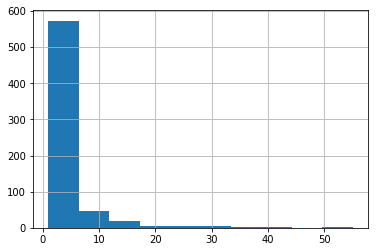

In [249]:
pd.Series(ranks).hist()

*Before moving on to exploratory analysis, write down some notes about challenges encountered while working with this data that might be helpful for anyone else (including yourself) who may work through this later on.*

# Explore the Data

*Before you start exploring the data, write out your thought process about what you're looking for and what you expect to find. Take a minute to confirm that your plan actually makes sense.*

*Calculate summary statistics and plot some charts to give you an idea what types of useful relationships might be in your dataset. Use these insights to go back and download additional data or engineer new features if necessary. Not now though... remember we're still just trying to finish the MVP!*

In [11]:
## %%writefile ../src/visualization/visualize.py

# Imports
from itertools import cycle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import hvplot.pandas

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Parameters
int_drink_path = '../data/interim/drink_list.pickle'
proc_data_path = '../data/processed/dt_matrix.pickle'
vectorizer_path = '../models/vectorizer.pkl'
X_topics_path = '../data/processed/X_topics.pkl'

# Helper functions go here
def visualize_topics(X, y, suggested):
    tsne = TSNE(n_components=2)
    X_2D = tsne.fit_transform(X)
    
#     print('X TSNE')
    X_2D = pd.DataFrame(X_2D, index=X.index).reset_index()
    X_2D.columns = ['Cocktail', 'Topic 1', 'Topic 2', ]
#     display(X_2D.head())
    
#     print('Y_TSNE')
    y_2D = X_2D[X_2D['Cocktail'] == suggested]
#     test_2D = test_2D.reset_index()
#     display(y_2D)
#     test_2D.columns = ['Cocktail', 'Topic 1', 'Topic 2']
#     display(y_2D)
    
#     print('Actual')
#     actual_2D = train_2D[train_2D['Cocktail'] == actual]
#     display(actual_2D)
    
    # Make plot
    p = X_2D.hvplot(x='Topic 1', y='Topic 2', 
                    hover_cols=['Cocktail'], kind='scatter',
                    width=800, height=800) * \
        y_2D.hvplot(x='Topic 1', y='Topic 2', 
                    hover_cols=['Cocktail'], kind='scatter')
    display(p)
    

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if ix > 4:
            break
        if not topic_names or not topic_names[ix]:
            print("\nCategory ", ix + 1)
        else:
            print("\nCategory: '", topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    pass


def predict(testing=0):
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    vectorizer = load_from(vectorizer_path)
    svd = load_from('../models/svd.pkl')
    X_topics = load_from(X_topics_path)
    
    display_topics(svd, vectorizer.get_feature_names(), 5)
    
    if testing:
        actual = 'Kamikazi'
#         print(f'***TESTING: This request should yield a "{actual}"')
        print('\nHow would you like your drink?\n')
        request = 'I want something sweet, smokey, savory and probably up to no good. Maybe a mezcal base, salt and honey?'
#         request = "When this shooter is done right no chaser is required. Dating back to the days of disco, the Kamikaze shooter allowed for the best kind of saturday night fever. Kamikaze Combine vodka, triple sec, and lime juice in a shaker over ice; shake vigorously for 10-15 seconds. Strain into a rocks glass or into two shot glasses vodka shot liqueur Level: Easy Prep: 2 min Jigger Shot glass Cointreau, the crystal clear Orange Liqueur, founded in Angers, France, remains one of the world's most distinguished spirits with over 160 years of history. \n\n\nRenowned for its perfect balance of sweet and bitter orange peels and made with only the finest all-natural ingredients, Cointreau has a uniquely refreshing and complex taste. A versatile, 80 proof spirit, Cointreau can be enjoyed as the base spirit in many cocktails, such as the Cointreau Rickey, but is also an essential ingredient in the most popular cocktails including the Margarita, the Cosmopolitan, and the Sidecar. Liquor Liqueur, Cordials, & Schnapps Fruit Liqueur Rose's lime juice, often known simply as Rose's, is a concentrated fruit juice patented in 1867. This makes it the world's first concentrated bottled fruit juice drink. Extras Mixers, Syrups, & Bitters Bar Mixers"
        print(request)
    else:
        request = input('\nHow would you like your drink?\n')
    
    y_doc = clean_document(request)
    y_doc_vec = vectorizer.transform([y_doc])
    y_topic = svd.transform(y_doc_vec)
    
    cosine_sims = cosine_similarity(X_topics, y_topic).flatten()
    cos_sims_sorted = pd.Series(
        cosine_sims, 
        index=X_topics.index,
        name='Cosine Similarity'
    ).sort_values(ascending=False)
    suggested_cocktail = cos_sims_sorted.index[0]

    print('\nMost Similar Cocktails:')
    display(cos_sims_sorted.head())
    
    # TSNE
    visualize_topics(X_topics, y_topic, suggested_cocktail)
    
    
#     print('X_topics')
#     train_2D = X_topics.iloc[:, :2].reset_index()
#     train_2D.columns = ['Cocktail', 'Topic 1', 'Topic 2', ]
#     display(train_2D.head())
    
#     print('Y_topic')
#     test_2D = pd.DataFrame(y_topic[:, :2], index=[suggested_cocktail])
#     test_2D = test_2D.reset_index()
# #     display(test_2D)
#     test_2D.columns = ['Cocktail', 'Topic 1', 'Topic 2']
#     display(test_2D)
    
#     print('Actual')
#     actual_2D = train_2D[train_2D['Cocktail'] == actual]
#     display(actual_2D)
    
#     # Make plot
#     display(
#         train_2D.hvplot(x='Topic 1', y='Topic 2', hover_cols=['Cocktail'], kind='scatter') *
#         test_2D.hvplot(x='Topic 1', y='Topic 2', hover_cols=['Cocktail'], kind='scatter') *
#         actual_2D.hvplot(x='Topic 1', y='Topic 2', hover_cols=['Cocktail'], kind='scatter')
#     )
    
    return suggested_cocktail


def plot_2D(data, target, target_names):
#     colors = cycle(['r','g','b','c','m','y','orange','w','aqua','yellow'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.legend()
    pass

# plot_PCA_2D(VT, target=y_train, target_names=digits.target_names)
# sns.scatterplot(x=0, y=1, data=Vt, alpha=0.5)


def make_exp_var_plot(method):
    exp_var_ratio = method.explained_variance_ratio_
    
    plt.plot(np.cumsum(exp_var_ratio))
    plt.xlabel('# components')
    plt.ylabel('Cumulative explained variance');
    plt.title('Cumulative explained variance by method');
    return


def get_topics(dt_matrix, num_topics):
    
    lsa = TruncatedSVD(num_topics)
    X_topics = lsa.fit_transform(dt_matrix)
    X_topics = pd.DataFrame(X_topics, index=dt_matrix.index)

    save_to(X_topics, X_topics_path)
    
    expl_var = lsa.explained_variance_ratio_
    topic_word = pd.DataFrame(lsa.components_.round(3),
                 columns = dt_matrix.columns)

    return lsa


@load_or_make(proc_data_path, overwrite='y')
def get_doc_term_matrix(drink_list):
    docs = {drink: v['doc'] for drink, v in drink_list.items()}
    doc_matrix = pd.Series(docs)
#     display(doc_matrix)
    vectorizer = TfidfVectorizer(
        strip_accents='unicode',
        stop_words='english',
        ngram_range=(1, 2)
    )
    
    doc_vectors = vectorizer.fit_transform(doc_matrix)
#     display(pd.DataFrame(doc_vectors))
    
    save_to(vectorizer, vectorizer_path)

    dt_matrix = pd.DataFrame(
        doc_vectors.toarray(), 
        index=docs, 
        columns=vectorizer.get_feature_names()
    )
#     print('Doc-term matrix: cocktails and vocabulary')
#     display(dt_matrix.head())
    
    return dt_matrix


def run():
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    num_components = 250
    drink_list = load_from(int_drink_path)
    dt_matrix = get_doc_term_matrix(drink_list)
    svd = get_topics(dt_matrix, num_components)
    
    make_exp_var_plot(svd)
    save_to(svd, '../models/svd.pkl')
    
    drink_prediction = predict(testing=1)
    print(f"I'll make you a {drink_prediction}")
    drink = drink_list[drink_prediction]
    
    recipe = drink['recipeIngredient']
    print(f'\nThe recipe for that is:')
    for line in recipe:
        print('\t', line.replace('\n', ' ').replace('\xa0', ' '))
    
    url = drink['url']
    print(f'\nThis cocktail came from:\n{url}')
    # data = load_features('data/processed')
    # describe_features(data, 'reports/')
    # generate_charts(data, 'reports/figures/')
    return dt_matrix


Loaded file from ../data/interim/drink_list.pickle
Are you sure you want to overwrite ../data/processed/dt_matrix.pickle? y/n: y
Saved file to ../models/vectorizer.pkl
Saved file to ../data/processed/X_topics.pkl
Saved file to ../models/svd.pkl
Loaded file from ../models/vectorizer.pkl
Loaded file from ../models/svd.pkl
Loaded file from ../data/processed/X_topics.pkl

Category  1
liqueur, soda, vodka, juice, cocktail

Category  2
vodka, tito, head, distillation, tito handmade

Category  3
st germain, germain, liqueur, st, elderflower

Category  4
coffee, kahlua, liqueur, bailey, irish

Category  5
campari, ounce, gin, drink, tito

How would you like your drink?

I want something sweet, smokey, savory and probably up to no good. Maybe a mezcal base, salt and honey?

Most Similar Cocktails:


Pineapple Mezcal Smash             0.700821
Smoky Vanilla Mai Tai              0.657926
Grilled Summer Peach Margaritas    0.306402
Mezcal Michelada                   0.285210
Jack Honey on the Rocks            0.278542
Name: Cosine Similarity, dtype: float64

:Overlay
   .Scatter.I  :Scatter   [Topic 1]   (Topic 2,Cocktail)
   .Scatter.II :Scatter   [Topic 1]   (Topic 2,Cocktail)

I'll make you a Pineapple Mezcal Smash

The recipe for that is:
	 1.5 oz. mezcal 
	 2 oz. crushed pineapple (a can is fine!)
	 .5 oz. simple syrup
	 1 oz. Pineapple juice
	 One bunch of fresh mint

This cocktail came from:
https://drizly.com/Pineapple_Mezcal_Smash/r-06bea4420783c148


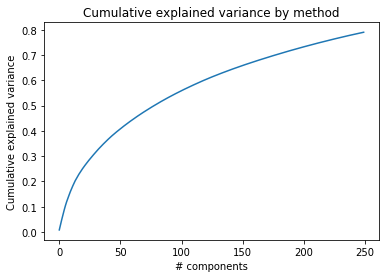

In [427]:
dt_matrix = run()


In [13]:
dt_matrix

NameError: name 'dt_matrix' is not defined

*What did you learn? What relationships do you think will be most helpful as you build your model?*

# Model the Data

*Describe the algorithm or algorithms that you plan to use to train with your data. How do these algorithms work? Why are they good choices for this data and problem space?*

In [ ]:
## %%writefile ../src/models/train_model.py

# imports
# helper functions go here

def run():
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    request = input('How would you like your drink?')
    svd = load_from('../models/svd.pkl')
    
    svd.predict()
    
    predict with method
    cosine similarity against all cocktails
    select and return max
    # data = load_features('data/processed/')
    # train, test = train_test_split(data)
    # save_train_test(train, test, 'data/processed/')
    # model = build_model()
    # model.fit(train)
    # save_model(model, 'models/')
    pass


In [ ]:
## %%writefile ../src/models/predict_model.py

# imports
# helper functions go here

def run():
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    
    # test_X, test_y = load_test_data('data/processed')
    # trained_model = load_model('models/')
    # predictions = trained_model.predict(test_X)
    # metrics = evaluate(test_y, predictions)
    # save_metrics('reports/')
    pass



_Write down any thoughts you may have about working with these algorithms on this data. What other ideas do you want to try out as you iterate on this pipeline?_

# Interpret the Model

_Write up the things you learned, and how well your model performed. Be sure address the model's strengths and weaknesses. What types of data does it handle well? What types of observations tend to give it a hard time? What future work would you or someone reading this might want to do, building on the lessons learned and tools developed in this project?_

# Universal Helpers

In [2]:
import os
import pickle

def load_or_make(filepath, overwrite='n'):
    def decorator(func):
        def wraps(*args, **kwargs):
            if overwrite == 'y':
                ow = input(f'Are you sure you want to overwrite {filepath}? y/n: ')
                if (os.path.exists(filepath)) and (ow == 'y'):
                    os.remove(filepath)
            try:
                with open(filepath, 'rb') as f:
                    data = pickle.load(f)
            except:
                data = func(*args, **kwargs)
                with open(filepath, 'wb') as to_write:
                    pickle.dump(data, to_write)
            return data
        return wraps
    return decorator


def save_to(item, filepath):
    """
    Pickles item sand saves it to path
    Input: object to be pickled, string containing directory and filename
    Output: pickled object stored to provided path
    """
    with open(filepath, 'wb') as to_write:
        pickle.dump(item, to_write)
    print(f'Saved file to {filepath}')
    return


def load_from(filepath):
    """
    Unpickles item and returns item from path
    Input: filepath to pickled object
    Output: unpickled object
    """
    if not file_exists(filepath):
        print(f'Failed to load from {filepath}. Does not exist.')
    with open(filepath, 'rb') as f:
        item = pickle.load(f)
    print(f'Loaded file from {filepath}')
    return item


def file_exists(filepath):
    """
    Returns True if specified file already exists, else False
    Input:
        path (str), path to directory containing file
        filename (str), name of file to check for
    Output: True if specified file already exists, else False
    """
    file_exists = os.path.isfile(filepath)
    return file_exists

